In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import gc
import os
import numpy as np
import shutil
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [16]:
# Setting CUDA devices as visible
cuda_devices = "0,1"
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_devices

In [17]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("Using GPUs:")
    for device_id in cuda_devices.split(','):
        device = torch.device(f"cuda:{device_id}")
        print(f"  Device {device_id}: {torch.cuda.get_device_name(int(device_id))}")
else:
    print("Using CPU")

Using GPUs:
  Device 0: Tesla P100-PCIE-16GB
  Device 1: Tesla P100-PCIE-16GB


In [18]:
torch.cuda.empty_cache()
gc.collect()

485

In [19]:
def get_classes(directory):
    class_list = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path) and os.listdir(item_path):
            class_list.append(item)
    return class_list

In [20]:
in_dir = "/mnt/nis_lab_research/data/class_data/neg/far_shah_b1-b5_b8_train_c10_neg"
out_dir = "../../data/classifier/far_shah_b1-b5_b8_train_c10_neg"
num_workers = 22
epochs = 30

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by ResNet
    transforms.ToTensor(),
    # CHANGE TO BE DATA SPECIFIC
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [22]:
def tt_split(input_dir, out_dir, train_ratio):
    """
    Splits the dataset in the given directory into train and test sets.

    :param input_dir: Path to the input directory.
    :param train_ratio: Ratio of train set (between 0 and 1).
    """
    if not 0 <= train_ratio <= 1:
        raise ValueError("Train ratio must be between 0 and 1")

    base_dir = out_dir
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')

    # Create train and test directories
    for directory in [train_dir, test_dir]:
        os.makedirs(directory, exist_ok=True)

    # Process each class directory
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        print(class_dir)
        if os.path.isdir(class_dir):
            # Create class directories in train and test
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

            # Get a list of images and shuffle them
            images = os.listdir(class_dir)
            random.shuffle(images)

            # Split images into train and test
            split_point = int(len(images) * train_ratio)
            train_images = images[:split_point]
            test_images = images[split_point:]

            # Copy images to train and test directories
            for image in train_images:
                shutil.copy2(os.path.join(class_dir, image), os.path.join(train_dir, class_name))
            for image in test_images:
                shutil.copy2(os.path.join(class_dir, image), os.path.join(test_dir, class_name))

In [23]:
if not os.path.exists(out_dir):
    tt_split(in_dir, out_dir, 0.8)

In [24]:
class_list = sorted(get_classes(os.path.join(out_dir, "test")))
num_classes = len(class_list)
print(num_classes)
print(class_list)

11
['Advertisement', 'Alert Notification', 'Button', 'Captcha', 'Checkbox', 'Input Box', 'Logo', 'Popup', 'Random', 'Toggle Button', 'Video']


In [25]:
train_set = torchvision.datasets.ImageFolder(root='../../data/classifier/' + in_dir.split("/")[-1] + '/train', transform=transform)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=num_workers)


In [26]:
test_set = torchvision.datasets.ImageFolder(root='../../data/classifier/' + in_dir.split("/")[-1] + '/test', transform=transform)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=num_workers)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # 27 total classes - text captcha have 0 so it is removed for now
model = model.to(device)
model = nn.DataParallel(model)  # Use DataParallel

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)


/home/pyt_user/miniconda3/envs/pyt_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pyt_user/miniconda3/envs/pyt_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
loss_list = []
for j, epoch in enumerate(range(epochs)):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}")
    for i, data in progress_bar:
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to the primary device
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (i + 1))
        loss_list.append(running_loss / (i + 1))
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
    torch.save(model, f'./checkpoints/ep_{j}.pth')
print('Finished Training')

Epoch 1/30: 100%|██████████| 875/875 [10:04<00:00,  1.45it/s, loss=0.33] 


Epoch 1, Loss: 0.3296328585318157


Epoch 2/30: 100%|██████████| 875/875 [10:02<00:00,  1.45it/s, loss=0.254]


Epoch 2, Loss: 0.25377225672347203


Epoch 3/30: 100%|██████████| 875/875 [10:10<00:00,  1.43it/s, loss=0.236]


Epoch 3, Loss: 0.23617297021831785


Epoch 4/30: 100%|██████████| 875/875 [09:55<00:00,  1.47it/s, loss=0.223]

Epoch 4, Loss: 0.22298239129781722



Epoch 5/30: 100%|██████████| 875/875 [09:49<00:00,  1.48it/s, loss=0.213]

Epoch 5, Loss: 0.21275679671764375



Epoch 6/30: 100%|██████████| 875/875 [09:48<00:00,  1.49it/s, loss=0.203]

Epoch 6, Loss: 0.2033772883074624



Epoch 7/30: 100%|██████████| 875/875 [09:49<00:00,  1.49it/s, loss=0.193]

Epoch 7, Loss: 0.19328837052413395



Epoch 8/30: 100%|██████████| 875/875 [09:46<00:00,  1.49it/s, loss=0.184]

Epoch 8, Loss: 0.18430390285594123



Epoch 9/30: 100%|██████████| 875/875 [09:46<00:00,  1.49it/s, loss=0.174]

Epoch 9, Loss: 0.17373149711745126



Epoch 10/30: 100%|██████████| 875/875 [09:46<00:00,  1.49it/s, loss=0.164]

Epoch 10, Loss: 0.16414798589263643



Epoch 11/30: 100%|██████████| 875/875 [09:46<00:00,  1.49it/s, loss=0.152]

Epoch 11, Loss: 0.15158278581074305



Epoch 12/30: 100%|██████████| 875/875 [09:45<00:00,  1.49it/s, loss=0.14] 

Epoch 12, Loss: 0.1401016353028161



Epoch 13/30: 100%|██████████| 875/875 [09:45<00:00,  1.50it/s, loss=0.13] 

Epoch 13, Loss: 0.12960765627878054



Epoch 14/30: 100%|██████████| 875/875 [09:45<00:00,  1.50it/s, loss=0.118]

Epoch 14, Loss: 0.11795095076731273



Epoch 15/30: 100%|██████████| 875/875 [09:49<00:00,  1.48it/s, loss=0.108] 

Epoch 15, Loss: 0.10834750187397003



Epoch 16/30: 100%|██████████| 875/875 [09:49<00:00,  1.48it/s, loss=0.101] 


Epoch 16, Loss: 0.10115452723843711


Epoch 17/30: 100%|██████████| 875/875 [09:46<00:00,  1.49it/s, loss=0.0944]

Epoch 17, Loss: 0.09443498677866799



Epoch 18/30: 100%|██████████| 875/875 [09:50<00:00,  1.48it/s, loss=0.0897]

Epoch 18, Loss: 0.0896717585601977



Epoch 19/30: 100%|██████████| 875/875 [09:52<00:00,  1.48it/s, loss=0.085] 

Epoch 19, Loss: 0.08499179774097033



Epoch 20/30: 100%|██████████| 875/875 [09:48<00:00,  1.49it/s, loss=0.0829]


Epoch 20, Loss: 0.08292761707093034


Epoch 21/30: 100%|██████████| 875/875 [09:47<00:00,  1.49it/s, loss=0.0796]

Epoch 21, Loss: 0.07956229330386434



Epoch 22/30: 100%|██████████| 875/875 [09:45<00:00,  1.49it/s, loss=0.077] 

Epoch 22, Loss: 0.07699524606338569



Epoch 23/30: 100%|██████████| 875/875 [09:52<00:00,  1.48it/s, loss=0.0736]


Epoch 23, Loss: 0.07363397397526673


Epoch 24/30: 100%|██████████| 875/875 [10:07<00:00,  1.44it/s, loss=0.0743]


Epoch 24, Loss: 0.07426043564294066


Epoch 25/30: 100%|██████████| 875/875 [09:50<00:00,  1.48it/s, loss=0.0701]

Epoch 25, Loss: 0.07007339433048453



Epoch 26/30: 100%|██████████| 875/875 [09:45<00:00,  1.49it/s, loss=0.0702]

Epoch 26, Loss: 0.07016273954297815



Epoch 27/30: 100%|██████████| 875/875 [09:47<00:00,  1.49it/s, loss=0.0676]

Epoch 27, Loss: 0.06764701536191361



Epoch 28/30: 100%|██████████| 875/875 [09:44<00:00,  1.50it/s, loss=0.0665]

Epoch 28, Loss: 0.06651248003116676



Epoch 29/30: 100%|██████████| 875/875 [09:45<00:00,  1.49it/s, loss=0.0651]

Epoch 29, Loss: 0.06512532010674477



Epoch 30/30: 100%|██████████| 875/875 [09:44<00:00,  1.50it/s, loss=0.064] 

Epoch 30, Loss: 0.06398580673869167
Finished Training


In [29]:
# Can be saved directly from the GPU
torch.save(model, './pth/rn50_c10_neg_ep30.pth')

In [30]:
# # To load the model later
# model = torch.load('./pth/test_ep25.pth')

In [31]:
model.eval()  # Set the model to evaluation mode

# Variables to hold predictions and actual labels
y_pred = []
y_true = []
y_score = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Assuming outputs are raw scores from your model
        _, predicted = torch.max(outputs.data, 1)
        
        # Accumulate true labels and predictions
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_score.extend(probabilities.cpu().numpy())
        

In [32]:
len(y_pred)

55956

In [33]:
num_classes

11

In [34]:
gt_by_class = []
for i in range (0, num_classes):
    tmp = []
    for j, gt in enumerate(y_true):
        if i == gt:
            tmp.append([gt, y_pred[j]])
        
    gt_by_class.append(tmp)
     

In [35]:
gt_by_class

[[[0, 8],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 2],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 6],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 8],
  [0, 7],
  [0, 10],
  [0, 0],
  [0, 8],
  [0, 2],
  [0, 0],
  [0, 0],
  [0, 8],
  [0, 0],
  [0, 2],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 1],
  [0, 0],
  [0, 6],
  [0, 0],
  [0, 8],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 8],
  [0, 0],
  [0, 8],
  [0, 0],
  [0, 8],
  [0, 8],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 2],
  [0, 0],
  [0, 8],
  [0, 2],
  [0, 0],
  [0, 8],
  [0, 8],
  [0, 0],
  [0, 0],
  [0, 8],
  [0, 1],
  [0, 0],
  [0, 0],
  [0, 8],
  [0, 8],
  [0, 8],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 8],
  [0, 2],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 8],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 8],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 7],
  [0, 0],
  [0, 2],
  [0, 0],
  [0, 1],
  [0, 0],
  [0, 8],
  [0, 0],
  [0, 8],
  [0, 8],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 8],
  [0, 0],

In [36]:
tot = 0 
for i, class_ in enumerate(gt_by_class):
    class_cntr = 1
    for inst in class_:
        if inst[0] == inst[1]:
            class_cntr += 1
    print(i, class_list[i], class_cntr)
    tot = tot + class_cntr / len(class_)

0 Advertisement 160
1 Alert Notification 527
2 Button 20984
3 Captcha 16
4 Checkbox 115
5 Input Box 754
6 Logo 1951
7 Popup 118
8 Random 27033
9 Toggle Button 36
10 Video 135


In [37]:
tot/len(gt_by_class)

0.7840262818463415

In [38]:
# Ensure the directory exists
os.makedirs('res', exist_ok=True)

In [39]:
print(len(y_pred))
print(len(y_true))
print(len(y_score))

55956
55956
55956


OVERALL METRICS
Accuracy: 92.60%
Precision: 0.9254
Recall: 0.9260
F1 Score: 0.9250

Advertisement (class 0): 64.90%

Alert Notification (class 1): 80.06%

Button (class 2): 91.71%

Captcha (class 3): 71.43%

Checkbox (class 4): 78.62%

Input Box (class 5): 80.88%

Logo (class 6): 71.90%

Popup (class 7): 70.91%

Random (class 8): 96.62%

Toggle Button (class 9): 68.63%

Video (class 10): 77.46%



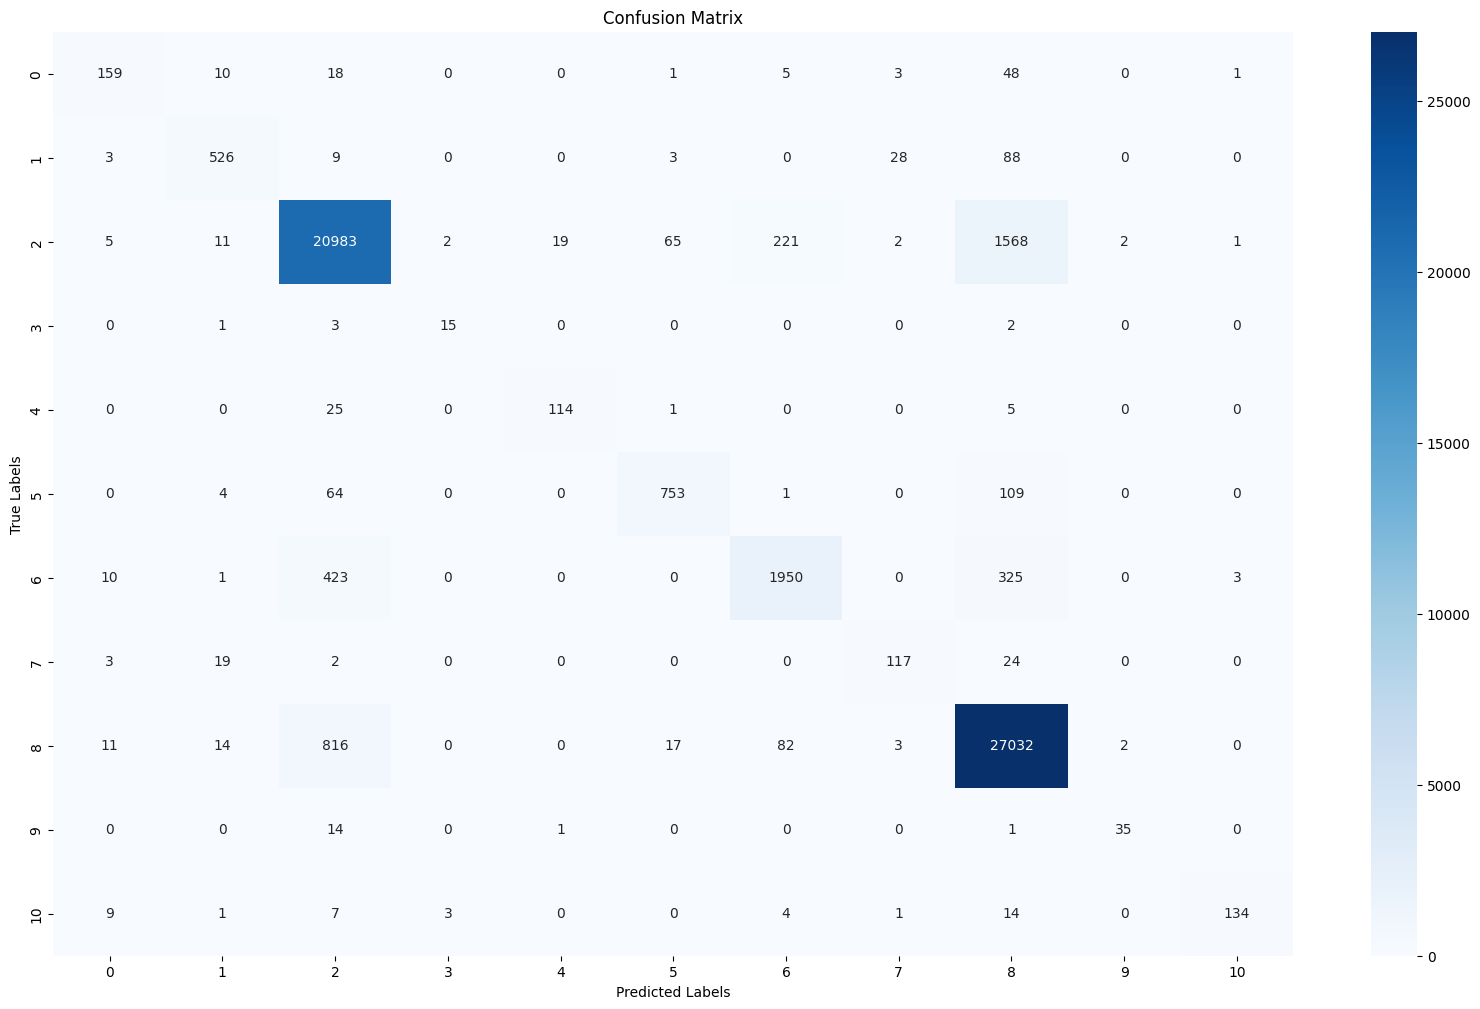

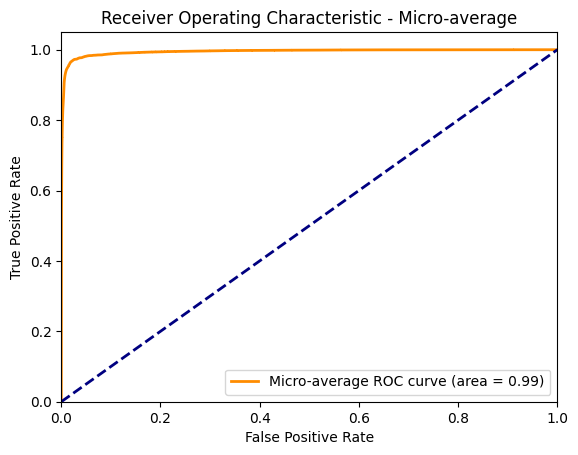

In [40]:

# Open a file to write the outputs
with open('res/results.txt', 'w') as f:

    # Convert accumulated predictions and labels to numpy arrays
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # Determine the unique classes in y_true and binarize
    classes = np.unique(y_true)  # Identify unique class labels
    y_true_binarized = label_binarize(y_true, classes=classes)

    n_classes = len(classes)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true)
    precision = precision_score(y_true, y_pred, average="weighted", labels=classes)
    recall = recall_score(y_true, y_pred, average="weighted", labels=classes)
    f1 = f1_score(y_true, y_pred, average="weighted", labels=classes)

    # ROC Curve and AUC for Micro-average
    fpr, tpr, _ = roc_curve(y_true_binarized.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    # Print and write metrics to file
    metrics_output = f"OVERALL METRICS\nAccuracy: {accuracy * 100:.2f}%\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\n"
    print(metrics_output)
    f.write(metrics_output)

    # Calculate accuracy by class
    accuracies_by_class = {}
    for cls in classes:
        idx = np.where(y_true == cls)[0]
        accuracy_cls = accuracy_score(y_true[idx], y_pred[idx])
        accuracies_by_class[cls] = accuracy_cls

    # Print and write accuracy by class to file
    f.write("\nACCURACY BY CLASS\n")
    for cls, acc in accuracies_by_class.items():
        class_output = f'{class_list[cls]} (class {cls}): {acc * 100:.2f}%\n'
        print(class_output)
        f.write(class_output)

    # Calculate and visualize the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(20, 12))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig('res/confusion_matrix.png')
    plt.show()

    # Plot ROC Curve for Micro-average
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Micro-average')
    plt.legend(loc='lower right')
    plt.show()